In [48]:
from itertools import combinations
from math import ceil

import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import zuko

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import air_traffic_network_model
from bayes_air.network import NetworkState
from bayes_air.schedule import parse_schedule

matplotlib.rcParams["figure.dpi"] = 300

In [49]:
# Load the data
top_n = 10
n_failure = 2
n_nominal = 2
n_calibration_permutations = 5
include_cancellations = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# Load the data
df = pd.read_pickle("../../../data/wn_data_clean_mst.pkl")
df = ba_dataloader.top_N_df(df, top_n)
nominal_df, disrupted_df = ba_dataloader.split_nominal_disrupted_data(df)
nominal_dfs = ba_dataloader.split_by_date(nominal_df)
disrupted_dfs = ba_dataloader.split_by_date(disrupted_df)

# Get just the set of data we want to study
nominal = nominal_dfs[-n_nominal:]
failure = disrupted_dfs[: 2 * n_failure : 2]
n_failure_eval = n_failure
failure_eval = disrupted_dfs[1 : 1 + n_failure : 2]

# Filter out cancellations if we're not using them
if not include_cancellations:
    nominal = [df[~df["cancelled"]] for df in nominal]
    failure = [df[~df["cancelled"]] for df in failure]
    failure_eval = [df[~df["cancelled"]] for df in failure_eval]

# Convert each day into a schedule
nominal_states = []
failure_states = []
failure_eval_states = []

for day_df in nominal:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    nominal_states.append(state)

for day_df in failure:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    failure_states.append(state)

for day_df in failure_eval:
    flights, airports = parse_schedule(day_df, device=device)

    state = NetworkState(
        airports={airport.code: airport for airport in airports},
        pending_flights=flights,
    )
    failure_eval_states.append(state)

# Get some information about the network that will be needed to map
# the vector posterior to the sample sites in the probabilistic model
airport_codes = list(nominal_states[0].airports.keys())
n_airports = len(airport_codes)
pairs = list(combinations(airport_codes, 2))
n_latent_variables = (
    n_airports  # mean turnaround time for each airport
    + n_airports  # mean service time for each airport
    + n_airports * n_airports  # travel time between each pair of airports
)
if include_cancellations:
    n_latent_variables += n_airports  # log # of initial aircraft for each airport
    n_latent_variables += n_airports  # baseline cancel prob for each airport

n_latent_variables

120

In [50]:
# Define plotting functions
def map_to_sample_sites(sample):
    """Map vectorized samples to sample sites in the probabilistic model."""
    # Handle batched samples
    single_sample = len(sample.shape) == 1
    if single_sample:
        sample = sample.unsqueeze(0)

    assert sample.shape[-1] == n_latent_variables

    # Reshape & reparameterize the sample to satisfy positivity constraints
    airport_turnaround_times = torch.exp(sample[:, :n_airports])
    airport_service_times = torch.exp(sample[:, n_airports : 2 * n_airports])
    if include_cancellations:
        log_airport_initial_available_aircraft = sample[
            :, 2 * n_airports : 3 * n_airports
        ]
        log_airport_base_cancel_prob = sample[:, 3 * n_airports : 4 * n_airports]
        travel_times = torch.exp(
            sample[:, 4 * n_airports :].reshape(-1, n_airports, n_airports)
        )
    else:
        travel_times = torch.exp(
            sample[:, 2 * n_airports :].reshape(-1, n_airports, n_airports)
        )

    # Map to sample sites in the model
    conditioning_dict = {}
    for i, code in enumerate(airport_codes):
        conditioning_dict[f"{code}_mean_turnaround_time"] = airport_turnaround_times[
            :, i
        ]
        conditioning_dict[f"{code}_mean_service_time"] = airport_service_times[:, i]
        if include_cancellations:
            conditioning_dict[
                f"{code}_log_initial_available_aircraft"
            ] = log_airport_initial_available_aircraft[:, i]
            conditioning_dict[
                f"{code}_base_cancel_logprob"
            ] = log_airport_base_cancel_prob[:, i]

    for i, origin in enumerate(airport_codes):
        for j, destination in enumerate(airport_codes):
            if origin != destination:
                conditioning_dict[f"travel_time_{origin}_{destination}"] = travel_times[
                    :, i, j
                ]

    # Remove the batch dimension if it wasn't there before
    if single_sample:
        conditioning_dict = {
            key: value.squeeze(0) for key, value in conditioning_dict.items()
        }

    return conditioning_dict

@torch.no_grad()
def plot_travel_times(*sample_maps, labels=None):
    # Make subplots for each travel time pair
    rows = n_airports
    subplot_spec = []
    for i in range(rows):
        subplot_spec.append([f"{i},{j}" for j in range(rows)])

    fig = plt.figure(figsize=(4 * rows, 4 * rows))
    axs = fig.subplot_mosaic(subplot_spec, sharex=True, sharey=True)

    already_plotted = set()

    for i, origin in enumerate(airport_codes):
        for j, dest in enumerate(airport_codes):
            if origin == dest or (origin, dest) in already_plotted:
                axs[f"{i},{j}"].axis("off")
                continue

            already_plotted.add((origin, dest))
            already_plotted.add((dest, origin))

            for k, sample_map in enumerate(sample_maps):
                axs[f"{i},{j}"].scatter(                    
                    sample_map[f"travel_time_{origin}_{dest}"].cpu(),
                    sample_map[f"travel_time_{dest}_{origin}"].cpu(),
                    marker=".",
                    s=1,
                    label=labels[k] if labels else None,
                )

            axs[f"{i},{j}"].set_xlim(0, 8)
            axs[f"{i},{j}"].set_ylim(0, 8)
            axs[f"{i},{j}"].set_xlabel(f"{origin} -> {dest} travel time (hr)")
            axs[f"{i},{j}"].set_ylabel(f"{dest} -> {origin} travel time (hr)")
            axs[f"{i},{j}"].legend()

    fig.tight_layout()

    return fig


@torch.no_grad()
def plot_initial_aircraft(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                torch.exp(sample_map[f"{code}_log_initial_available_aircraft"]).cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} aircraft reserve")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 30)
        axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_base_cancel_prob(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                torch.exp(sample_map[f"{code}_base_cancel_logprob"]).cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} cancel prob")
        axs[f"{i}"].set_xlim(-0.05, 1.0)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_service_times(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                sample_map[f"{code}_mean_service_time"].cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} service time (hr)")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 1.05)
        axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig


@torch.no_grad()
def plot_turnaround_times(*sample_maps, labels=None):
    # Make subplots for each airport
    max_rows = 2
    max_plots_per_row = ceil(n_airports / max_rows)
    subplot_spec = []
    for i in range(max_rows):
        subplot_spec.append(
            [f"{i * max_plots_per_row +j}" for j in range(max_plots_per_row)]
        )

    fig = plt.figure(figsize=(4 * max_plots_per_row, 4 * max_rows))
    axs = fig.subplot_mosaic(subplot_spec)

    for i, code in enumerate(airport_codes):
        for j, sample_map in enumerate(sample_maps):
            axs[f"{i}"].hist(
                sample_map[f"{code}_mean_turnaround_time"].cpu(),
                bins=64,
                density=True,
                label=labels[j] if labels else None,
                alpha=1 / len(sample_maps),
            )

        axs[f"{i}"].set_xlabel(f"{code} turnaround time (hr)")
        x_min, x_max = axs[f"{i}"].get_xlim()
        x_min = min(x_min, -0.05)
        x_max = max(x_max, 1.05)
        # axs[f"{i}"].set_xlim(x_min, x_max)
        axs[f"{i}"].legend()

    return fig

In [51]:
# Load the trained model
failure_guide = zuko.flows.NSF(
    features=n_latent_variables,
    context=n_calibration_permutations,
    hidden_features=(64, 64),
).to(device)
state_dict = torch.load("./models/top-10-nocancel-failure_checkpoint_299.pt")
failure_guide.load_state_dict(state_dict["failure_guide"])
mixture_label = state_dict["mixture_label"]
nominal_label = torch.zeros_like(mixture_label)
failure_guide.eval();

In [52]:
# Draw some samples and compare
with torch.no_grad():
    failure_samples = failure_guide(mixture_label).sample((1000,))
    failure_sample_maps = map_to_sample_sites(failure_samples)
    nominal_samples = failure_guide(nominal_label).sample((1000,))
    nominal_sample_maps = map_to_sample_sites(nominal_samples)

    sample_maps = [nominal_sample_maps, failure_sample_maps]
    labels = ["Nominal", "Failure"]

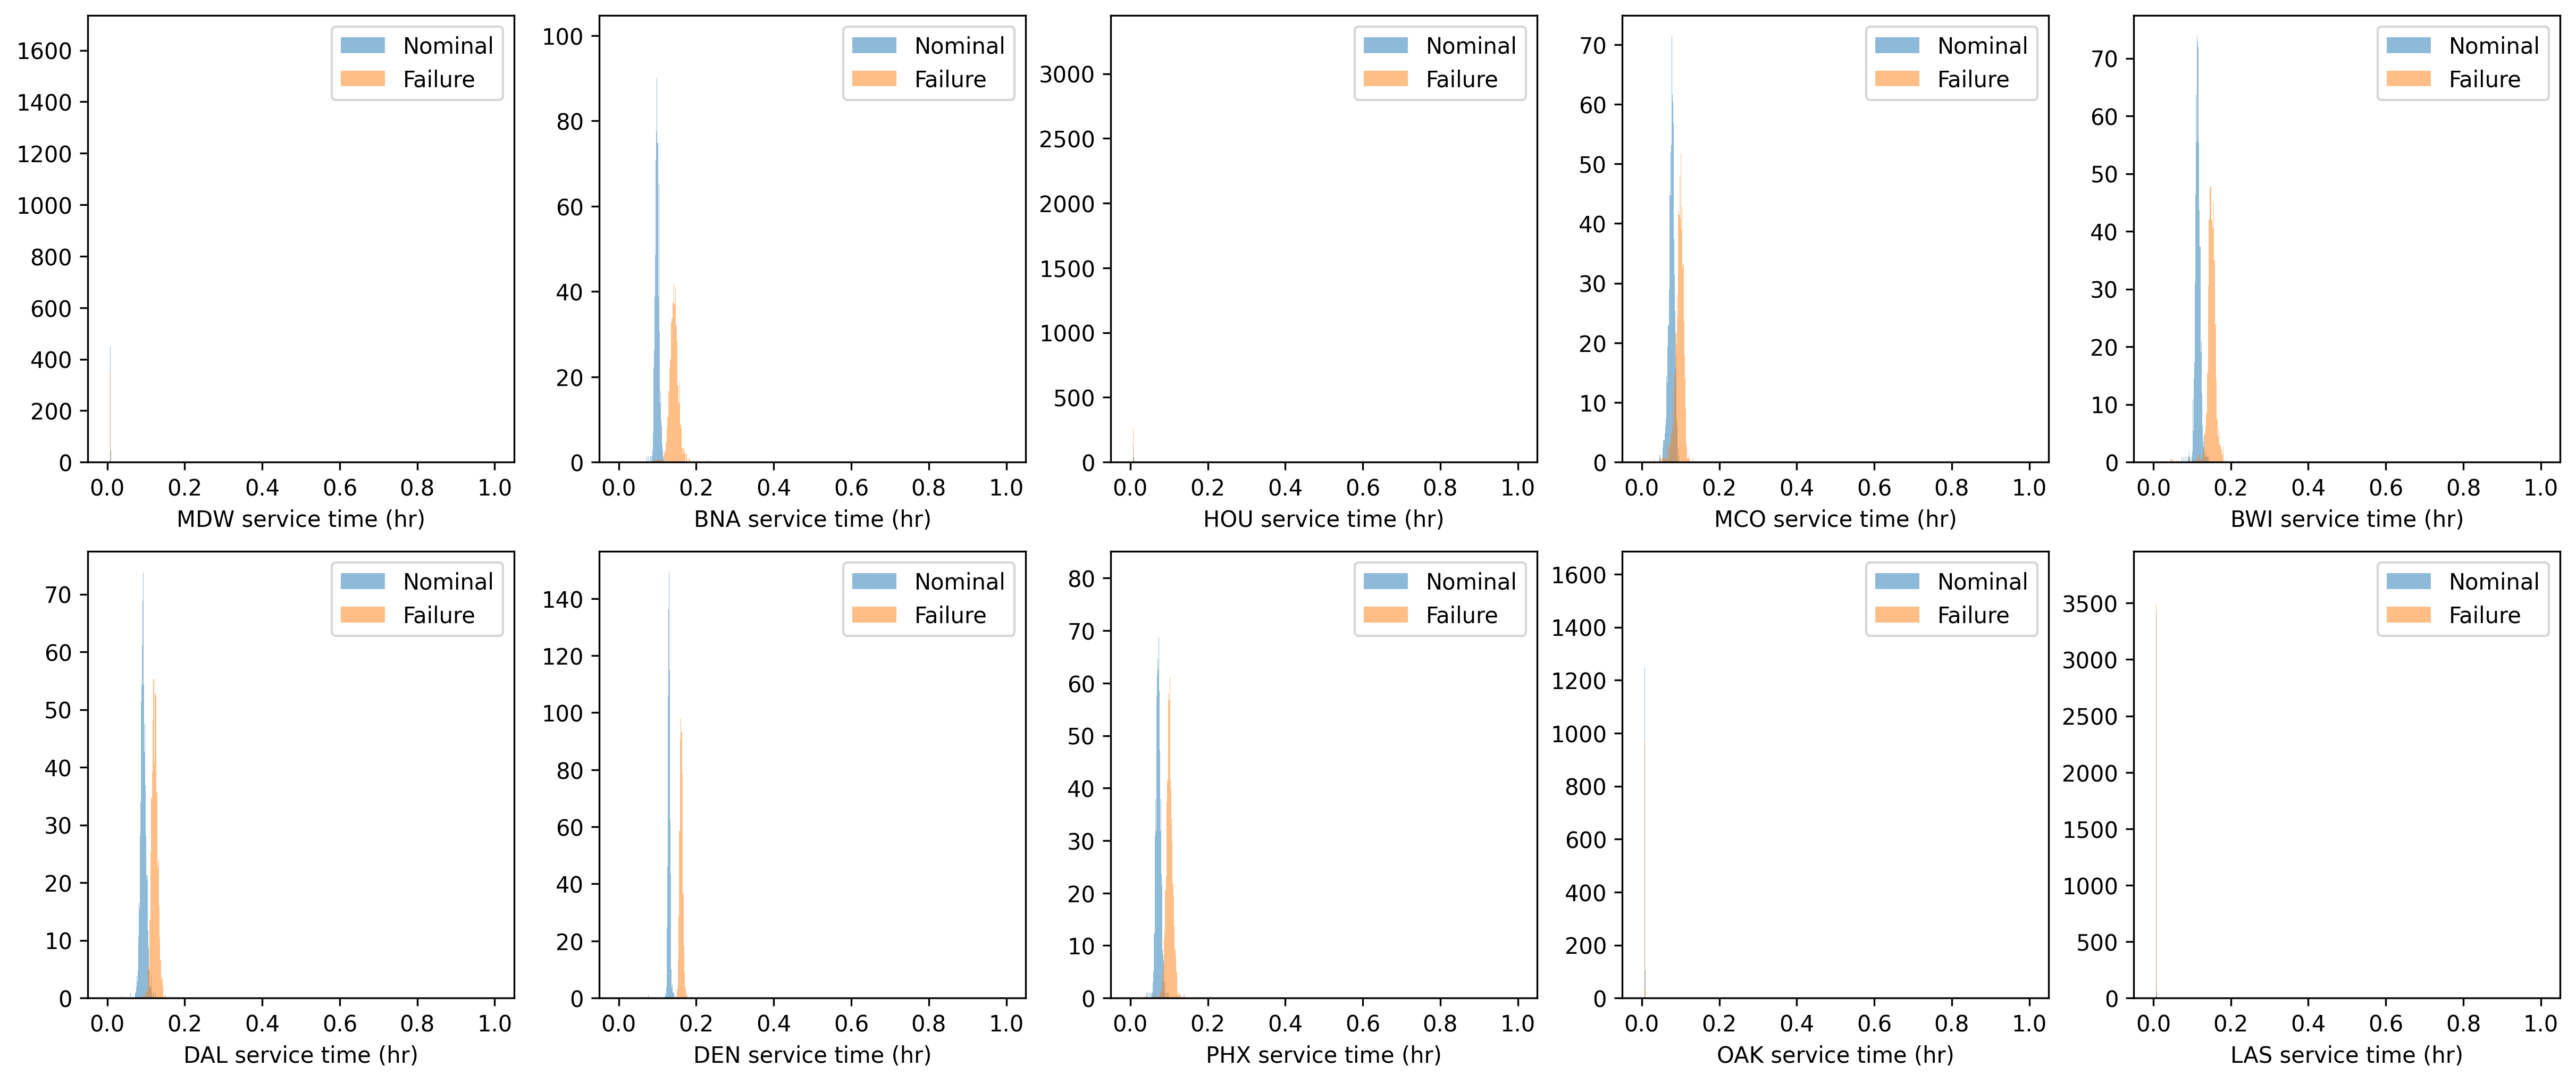

In [53]:
fig = plot_service_times(*sample_maps, labels=labels)

In [54]:
fig = plot_travel_times(*sample_maps, labels=labels)